<p style="font-size:32px;text-align:center"><font color=MediumVioletRed><b>Netflix Movie Recommendations</b></font></p>
<p style="font-size:20px;text-align:center"><b><font color=DarkGoldenRod>Part 1</font></b></p>

<h3><font color=Teal>Business Problem Description</font></h3>
- <p style="font-size:15px">**Netflix** is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. **Netflix** use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while Cinematch is doing pretty well, it can always be made better.</p>
- <p style="font-size:15px">Now there are a lot of interesting alternative approaches to how Cinematch works that **Netflix** haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business.</p>
    
<h3><font color=Teal>Problem Statement</font></h3>
- <p style="font-size:15px">**Netflix** provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings)</p>   
 
    <p style="font-size:15px">Credits : <a href="https://www.kaggle.com/netflix-inc/netflix-prize-data">Kaggle</a></p>
    
<h3><font color=Teal>Real World/Business Objectives and Constraints</font></h3>
<p style="font-size:17px">**Objectives:**</p>
<p style="font-size:15px">1. Predict the rating that a user would give to a movie that he ahs not yet rated.<br>
2. Minimize the difference between predicted and actual rating (RMSE and MAPE)</p>
<p style="font-size:17px">**Constraints:**</p>
<p style="font-size:15px">1. Some form of Interpretability.<br>
2. Minimize <a href="https://en.wikipedia.org/wiki/Root-mean-square_deviation">RMSE</a> (Root Mean Square Error)</p>

<h3><font color=Teal>Data</font></h3>
<p style="font-size:15px">Get the data from : <a href="https://www.kaggle.com/netflix-inc/netflix-prize-data">Kaggle</a></p>

<h3><font color=Teal>Type of Machine Learning Problem</font></h3>
<p style="font-size:15px">1. For a given movie and user we need to predict the rating would be given by him/her to the movie. <br>
2. The given problem is a Recommendation Problem.<br>
3. It can also seen as a Regression Problem.
</p>


In [2]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

import os
os.chdir("D:/Applied_Ai/Case Studies/Netflix Movie Recommendation")

<h3><font color=DarkMagenta>Loading and Reading Data</font></h3>

In [3]:
#we have four text files - combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt
os.chdir("D:/Applied_Ai/Case Studies/Netflix Movie Recommendation")

<p style="font-size:15px"><b><font color=SaddleBrown>Converting/Merging Whole Data To Required Format: u_i, m_j, r_ij</font></b></p>

In [5]:
if not os.path.isfile('data.csv'):
    start = datetime.now()
    #create a file 'data.csv' before reading it
    #read all the files in netflix and store them in one big file('data.csv')
    #we re reading from each of the four files and appendig each rating to a global file 'train.csv'
    
    data = open('data.csv', mode='w')
    
    row = list()
    files=['data_folder/combined_data_1.txt','data_folder/combined_data_2.txt', 
           'data_folder/combined_data_3.txt', 'data_folder/combined_data_4.txt']
    for file in files:
        print("Reading Ratings From {}".format(file))
        with open(file) as f:
            for line in f: 
                del row[:]
                line = line.strip() #removes any leading (spaces at the beginning) and trailing (spaces at the end) characters
                if line.endswith(':'):
                    #all below are ratings for this movie, until another movie appears
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done...\n")
        print('Time Taken :', datetime.now() - start)
    data.close()

In [6]:
print("Creating The Dataframe From 'data.csv' File..")
ratings_data = pd.read_csv('data.csv', sep=',', names=['movie','user','rating','date'])
ratings_data.date = pd.to_datetime(ratings_data.date) #method helps to convert string Date time into Python Date time object
print('Done...\n')

#we are arranging/sorting the ratings according to time
print('Sorting The Dataframe By Date..')
ratings_data.sort_values(by='date', inplace=True)
print('Done...')

Creating The Dataframe From 'data.csv' File..
Done...

Sorting The Dataframe By Date..
Done...


In [7]:
ratings_data.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [ ]:
ratings_data.to_csv("ratings_data.csv", index=False)

In [8]:
ratings_data.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

<p style="font-size:15px"><b><font color=SaddleBrown>Checking For NaN Values</font></b></p>

In [11]:
#just to make sure that all the NaN containing rows are deleted
print("NUMBER OF NAN VALUES IN THE DATASET -",sum(ratings_data.isnull().any()))

NUMBER OF NAN VALUES IN THE DATASET - 0


<p style="font-size:15px"><b><font color=SaddleBrown>Removing Duplicates</font></b></p>

In [12]:
dup_data = ratings_data.duplicated(['movie','user','rating'])
dup_sum = sum(dup_data) #by considering all columns (including timestamp)
print("THERE ARE {} DUPLICATE RATING ENTRIES IN THE DATASET".format(dup_sum))

THERE ARE 0 DUPLICATE RATING ENTRIES IN THE DATASET


<p style="font-size:15px"><b><font color=SaddleBrown>Basic Statistics</font></b></p>

In [13]:
print("TOTAL NUMBER OF RATINGS -",ratings_data.shape[0])
print("TOTAL NUMBER OF USERS -",len(np.unique(ratings_data['user'])))
print("TOTAL NUMBER OF MOVIES -",len(np.unique(ratings_data['movie'])))

TOTAL NUMBER OF RATINGS - 100480507
TOTAL NUMBER OF USERS - 480189
TOTAL NUMBER OF MOVIES - 17770


<h3><font color=DarkMagenta>Spliting Data Into Train and Test (80:20)</font></h3>

In [15]:
#we already sorted data according to date and now split data based on date (Time Based Spliting)
if not os.path.isfile("train_data.csv"):
    #create the dataframe and store it in the disk for offline purposes
    ratings_data.iloc[:int(ratings_data.shape[0]*0.80)].to_csv("train_data.csv", index=False)

if not os.path.isfile("test_data.csv"):
    #create the dataframe and store it in the disk for offline purposes
    ratings_data.iloc[int(ratings_data.shape[0]*0.80):].to_csv("test_data.csv", index=False)

In [23]:
train_data = pd.read_csv("train_data.csv", parse_dates=['date'])
test_data = pd.read_csv("test_data.csv")

<p style="font-size:15px"><b><font color=SaddleBrown>Basic Statistics On Train Data</font></b></p>

In [17]:
print("TOTAL NUMBER OF RATINGS -",train_data.shape[0])
print("TOTAL NUMBER OF USERS -",len(np.unique(train_data['user'])))
print("TOTAL NUMBER OF MOVIES -",len(np.unique(train_data['movie'])))

TOTAL NUMBER OF RATINGS - 80384405
TOTAL NUMBER OF USERS - 405041
TOTAL NUMBER OF MOVIES - 17424


<p style="font-size:15px"><b><font color=SaddleBrown>Basic Statistics On Test Data</font></b></p>

In [25]:
print("TOTAL NUMBER OF RATINGS -",test_data.shape[0])
print("TOTAL NUMBER OF USERS -",len(np.unique(test_data['user'])))
print("TOTAL NUMBER OF MOVIES -",len(np.unique(test_data['movie'])))

TOTAL NUMBER OF RATINGS - 20096102
TOTAL NUMBER OF USERS - 349312
TOTAL NUMBER OF MOVIES - 17757


<h3><font color=DarkMagenta>Exploratory Data Analysis On Train Data</font></h3>

<p style="font-size:15px"><b><font color=SaddleBrown>Distribution of Ratings</font></b></p>

In [54]:
#method to make y-axis more readable
def y_axis(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

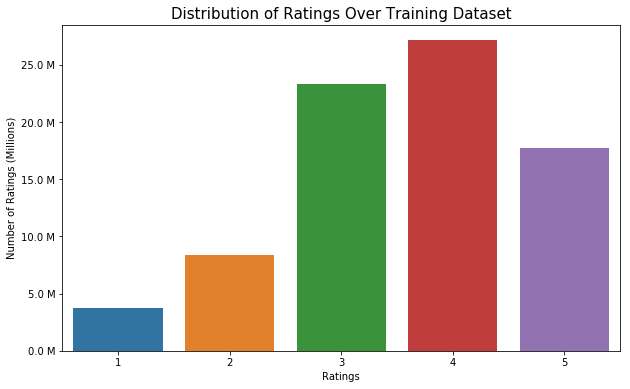

In [56]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Distribution of Ratings Over Training Dataset', fontsize=15)
sns.countplot(train_data.rating)

ax.set_yticklabels([y_axis(num, 'M') for num in ax.get_yticks()])
ax.set_ylabel('Number of Ratings (Millions)')
ax.set_xlabel('Ratings')

plt.show()

<p style="font-size:15px"><b><font color=SaddleBrown>Add New Column "Day" In Dataset For Data Analysis</font></b></p>

In [64]:
train_data['day_of_week'] = train_data['date'].dt.day_name()

train_data.head()

,movie,user,rating,date,day_of_week
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


<p style="font-size:15px"><b><font color=SaddleBrown>Number of Ratings Per Month</font></b></p>

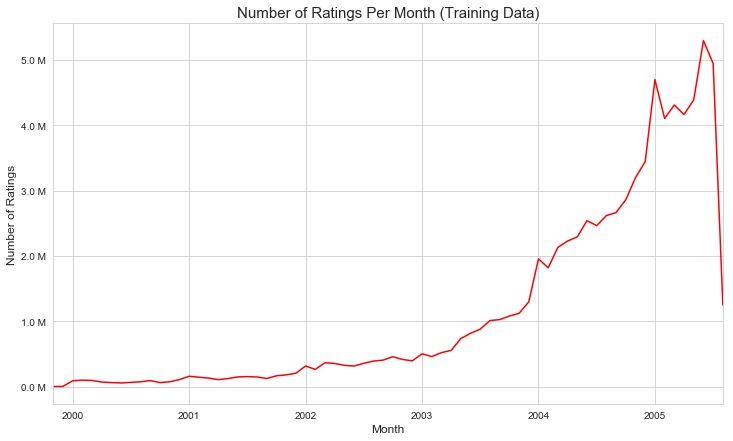

In [121]:
ax = plt.subplots(figsize=(12,7))
ax = train_data.resample('m', on='date')['rating'].count().plot(colormap='autumn')

ax.set_yticklabels([y_axis(num, 'M') for num in ax.get_yticks()])
ax.set_title("Number of Ratings Per Month (Training Data)", fontsize=15)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Ratings', fontsize=12)
#ax.grid()

plt.show()

<p style="font-size:15px"><b><font color=SaddleBrown>Analysis On The Ratings Given By User</font></b></p>

In [82]:
number_of_rated_movies_per_user = train_data.groupby(by='user')['rating'].count().sort_values(ascending=False)

number_of_rated_movies_per_user.head()

#user_305344 rated 17112 movies

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

In [99]:
number_of_rated_movies_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

In [100]:
quantiles = number_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

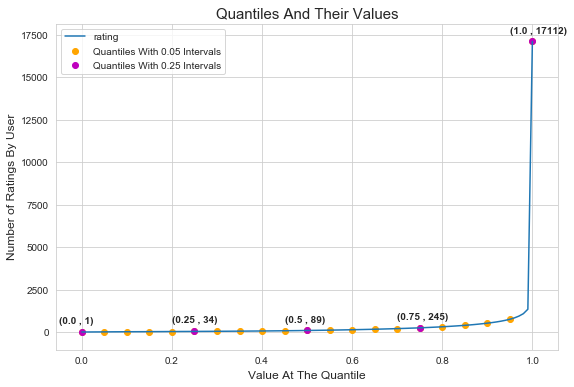

In [119]:
plt.figure(figsize=(9,6))
plt.title("Quantiles And Their Values", fontsize=15)
quantiles.plot()

#quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="Quantiles With 0.05 Intervals")

#quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "Quantiles With 0.25 Intervals")

plt.ylabel('Number of Ratings By User', fontsize=12)
plt.xlabel('Value At The Quantile', fontsize=12)
plt.legend(loc='best')

#annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500), fontweight='bold')

plt.show()

In [106]:
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

In [107]:
print('NUMBER OF RATINGS AT LAST 5 PERCENTILE - {}'.format(sum(number_of_rated_movies_per_user>=749)))

NUMBER OF RATINGS AT LAST 5 PERCENTILE - 20305


<p style="font-size:15px"><b><font color=SaddleBrown>Analysis On The Ratings of Movie Given By User</font></b></p>

In [113]:
number_of_ratings_per_movie = train_data.groupby(by='movie')['rating'].count().sort_values(ascending=False)

number_of_ratings_per_movie.head()

movie
5317     179684
15124    176811
1905     160062
6287     155787
14313    153899
Name: rating, dtype: int64

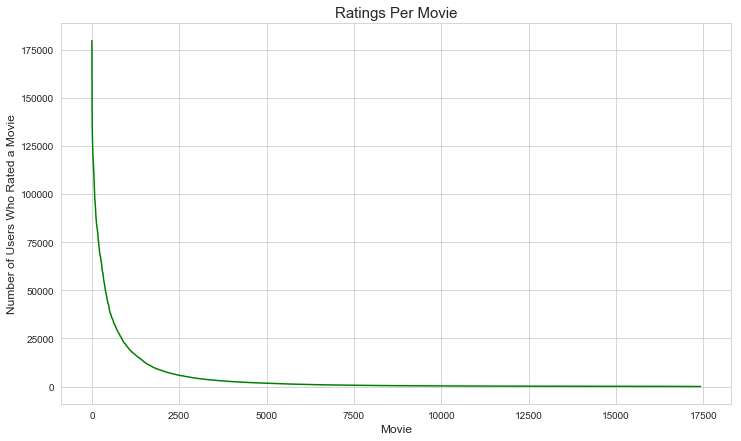

In [120]:
plt.figure(figsize=(12,7))

plt.plot(number_of_ratings_per_movie.values, 'g-')
plt.xlabel('Movie', fontsize=12)
plt.ylabel('Number of Users Who Rated a Movie', fontsize=12)
plt.title('Ratings Per Movie', fontsize=15)
plt.show()

<p style='font-size:15px'>Graph looks very skewed, just like nunmber of ratings given per user.</p>
<p style='font-size:15px'>- There are some movies (which are very popular) which are rated by huge number of users.</p>
<p style='font-size:15px'>- But most of the movies (like 90%) got some hundereds of ratings.</p>

<p style="font-size:15px"><b><font color=SaddleBrown>Number of Ratings On Each Day of The Week</font></b></p>

In [125]:
day_count = train_data.groupby(by='day_of_week')['rating'].count()

In [126]:
day_count.head(7)

day_of_week
Friday       10703108
Monday       13818790
Saturday      7963290
Sunday        8445834
Thursday     11634550
Tuesday      14221359
Wednesday    13597474
Name: rating, dtype: int64

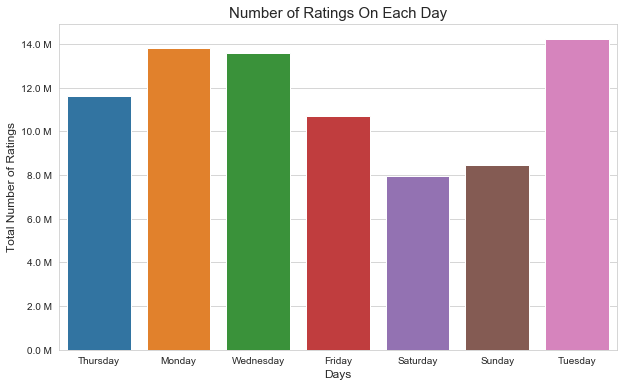

In [131]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Number of Ratings On Each Day', fontsize=15)

sns.countplot(train_data.day_of_week)
ax.set_yticklabels([y_axis(num, 'M') for num in ax.get_yticks()])
plt.ylabel('Total Number of Ratings', fontsize=12)
plt.xlabel('Days', fontsize=12)

plt.show()

In [132]:
avg_week_data = train_data.groupby(by=['day_of_week'])['rating'].mean()
print("Average Ratings")
print("-."*15)
print(avg_week_data)

Average Ratings
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64


<p style="font-size:20px;text-align:center"><b>Sparse and Similarity Matrix - Refer <a href="https://gitlab.com/akashbangalkar/netflix-movie-recommendation/-/blob/main/2_Netflix_Sim_Matrix.ipynb">Part 2</a> Notebook</b></p>